In [31]:
import numpy as np
import pandas as pd
import math as mh
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astral import LocationInfo
from astral.sun import sun
from datetime import datetime
from datetime import timedelta
import pytz
from scipy.optimize import minimize


temp= pd.read_csv(".csv", sep=";")

### Primo ciclo: rinomina la colonna con date in "Data"
for col in temp.columns:
    if pd.to_datetime(temp[col], errors='coerce').notna().all():
        temp.rename(columns={col: "Data"}, inplace=True)
        break  # Fermati appena trovi una colonna con date

### Secondo ciclo: rinomina la colonna con numeri in "St.Meteo/T.Aria (mm)"
for col in temp.columns:
    if pd.to_numeric(temp[col], errors='coerce').notna().all():
        temp.rename(columns={col: "St.Meteo/T.Aria (°C)"}, inplace=True)
        break  # Fermati appena trovi una colonna con numeri

RH= pd.read_csv(".csv", sep=";")

### Primo ciclo: rinomina la colonna con date in "Data"
for col in RH.columns:
    if pd.to_datetime(RH[col], errors='coerce').notna().all():
        RH.rename(columns={col: "Data"}, inplace=True)
        break  # Fermati appena trovi una colonna con date

### Secondo ciclo: rinomina la colonna con numeri in "St.Meteo/T.Aria (mm)"
for col in RH.columns:
    if pd.to_numeric(RH[col], errors='coerce').notna().all():
        RH.rename(columns={col: "St.Meteo/Um.Aria (%)"}, inplace=True)
        break  # Fermati appena trovi una colonna con numeri

for col in [col for col in RH.columns if 'Um.Aria' in col]:
    RH[col] = RH[col]/100
    
Combinati= pd.merge(temp, RH, on='Data', how='left')
Combinati['Data'] = pd.to_datetime(Combinati['Data'])

# Mantieni la prima colonna e le colonne che iniziano con 'ST.'
Combinati = Combinati[[Combinati.columns[0]] + [col for col in Combinati.columns if col.startswith('St.')]]

print(Combinati)

                    Data  St.Meteo/T.Aria (°C)  St.Meteo/Um.Aria (%)
0    2025-02-01 00:00:00                  8.17                0.9793
1    2025-02-01 01:00:00                  7.88                0.9805
2    2025-02-01 02:00:00                  7.65                0.9812
3    2025-02-01 03:00:00                  7.62                0.9822
4    2025-02-01 04:00:00                  7.62                0.9833
...                  ...                   ...                   ...
1769 2025-04-15 19:00:00                 18.60                0.7878
1770 2025-04-15 20:00:00                 16.22                0.8740
1771 2025-04-15 21:00:00                 14.28                0.9298
1772 2025-04-15 22:00:00                 13.25                0.9517
1773 2025-04-15 23:00:00                 12.80                0.9638

[1774 rows x 3 columns]


In [33]:
latitudine = float(input("Inserisci latitudine: "))
longitudine =  float(input("Inserisci longitudine: "))

# fuso orario dell'Italia (con gestione ora legale)
italia_tz = pytz.timezone("Europe/Rome")

def calcola_alba_tramonto(data, latitudine, longitudine):
    """Calcola l'orario dell'alba e del tramonto per una data specifica e posizione fissa in Italia."""
    
    # Definisce la posizione con il fuso orario corretto
    luogo = LocationInfo(name="MiaPosizione", region="Italia", latitude=latitudine, longitude=longitudine, timezone="Europe/Rome")

    # Converte la data in fuso orario italiano
    data_locale = italia_tz.localize(datetime(data.year, data.month, data.day))

    # Calcola gli orari astronomici per la data fornita
    orari_solari = sun(luogo.observer, date=data_locale, tzinfo=italia_tz)

    # Restituisce l'orario dell'alba e del tramonto nel fuso orario corretto
    return orari_solari["sunrise"], orari_solari["sunset"]

#  Applica la funzione calcola_tramonto per ogni riga con la data corrispondente
Combinati[['Alba', 'Tramonto']] = Combinati['Data'].apply(lambda date: pd.Series(calcola_alba_tramonto(date, latitudine, longitudine)))
Combinati['Tramonto'] = Combinati['Tramonto'].dt.strftime('%Y-%m-%d %H:%M:%S')
Combinati['Alba']= Combinati['Alba'].dt.strftime('%Y-%m-%d %H:%M:%S')
Combinati['Tramonto'] = pd.to_datetime(Combinati['Tramonto'])
Combinati['Alba'] = pd.to_datetime(Combinati['Alba'])

# Stampa il risultato
print(Combinati)

Inserisci latitudine:  44.272506
Inserisci longitudine:  12.070612


                    Data  St.Meteo/T.Aria (°C)  St.Meteo/Um.Aria (%)  \
0    2025-02-01 00:00:00                  8.17                0.9793   
1    2025-02-01 01:00:00                  7.88                0.9805   
2    2025-02-01 02:00:00                  7.65                0.9812   
3    2025-02-01 03:00:00                  7.62                0.9822   
4    2025-02-01 04:00:00                  7.62                0.9833   
...                  ...                   ...                   ...   
1769 2025-04-15 19:00:00                 18.60                0.7878   
1770 2025-04-15 20:00:00                 16.22                0.8740   
1771 2025-04-15 21:00:00                 14.28                0.9298   
1772 2025-04-15 22:00:00                 13.25                0.9517   
1773 2025-04-15 23:00:00                 12.80                0.9638   

                    Alba            Tramonto  
0    2025-02-01 07:29:54 2025-02-01 17:21:16  
1    2025-02-01 07:29:54 2025-02-01 17:21

In [35]:
# Se Alba è prima di Tramonto, aggiungi 1 giorno ad Alba per correggere il cambio di giorno
Combinati.loc[Combinati['Alba'] < Combinati['Tramonto'], 'Alba'] += timedelta(days=1)

# Creiamo una nuova colonna "Alba_succ" che contiene l'alba del giorno successivo per ogni riga
Combinati['Data_numero'] = Combinati['Data'].dt.date  # Estrai solo la data
Albe_per_giorno = Combinati.groupby('Data_numero')['Alba'].first().shift(1)  # Trova l'alba del giorno successivo
Combinati['Alba_succ'] = Combinati['Data_numero'].map(Albe_per_giorno)  # Assegna l'alba corretta

# Converte "Alba_succ" in datetime per confrontarla con "Data"
Combinati['Alba_succ'] = pd.to_datetime(Combinati['Alba_succ'])

# Definizione delle due fasce notturne:
notte_1 = (Combinati['Data'] >= Combinati['Tramonto'])  # Dopo il tramonto fino a mezzanotte
notte_2 = (Combinati['Data'] <= Combinati['Alba_succ'])  # Dopo mezzanotte fino all'alba del giorno successivo

# Applichiamo il filtro combinando le due condizioni
Combinati_filtrato = Combinati[notte_1 | notte_2]
Combinati_filtrato = Combinati_filtrato.dropna(subset=['Alba_succ'])

# Trova il primo giorno presente nel DataFrame filtrato
primo_giorno = Combinati_filtrato['Data'].dt.date.min()

# Calcola il giorno successivo
giorno_successivo = primo_giorno + timedelta(days=1)

# Trova l'orario di tramonto per il giorno successivo
tramonto_giorno_successivo = Combinati.loc[Combinati['Data'].dt.date == giorno_successivo, 'Tramonto'].iloc[0]

# Filtra i dati per mantenere solo quelli dal tramonto del giorno successivo in poi
Combinati_filtrato = Combinati_filtrato[Combinati_filtrato['Data'] >= tramonto_giorno_successivo].copy()

# Stampiamo il risultato per verifica
print(Combinati_filtrato)

                    Data  St.Meteo/T.Aria (°C)  St.Meteo/Um.Aria (%)  \
66   2025-02-03 18:00:00                  6.82                0.8322   
67   2025-02-03 19:00:00                  5.50                0.8833   
68   2025-02-03 20:00:00                  4.58                0.9035   
69   2025-02-03 21:00:00                  3.83                0.9180   
70   2025-02-03 22:00:00                  2.90                0.9310   
...                  ...                   ...                   ...   
1756 2025-04-15 06:00:00                 13.70                1.0000   
1770 2025-04-15 20:00:00                 16.22                0.8740   
1771 2025-04-15 21:00:00                 14.28                0.9298   
1772 2025-04-15 22:00:00                 13.25                0.9517   
1773 2025-04-15 23:00:00                 12.80                0.9638   

                    Alba            Tramonto Data_numero           Alba_succ  
66   2025-02-04 07:27:35 2025-02-03 17:24:04  2025-02-03

In [37]:
# Funzione per arrotondare l'orario al più vicino orario intero
def arrotonda_orario(dt):
    return (dt + timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)
    
#  Calcoliamo la differenza di tempo tra Data e Tramonto
Combinati_filtrato['Diff_Tempo'] = (Combinati_filtrato['Data'] - Combinati_filtrato['Tramonto']).abs()

# Troviamo la riga con il valore più vicino al tramonto per ogni giorno
Tramonto_vicino = Combinati_filtrato.loc[Combinati_filtrato.groupby(Combinati_filtrato['Data'].dt.date)['Diff_Tempo'].idxmin()].copy()

# Rimuoviamo la colonna temporanea
Tramonto_vicino.drop(columns=['Diff_Tempo'], inplace=True)

# Applica la funzione di arrotondamento sulla colonna 'Data'
Tramonto_vicino['Tramonto_arrotondato'] = Tramonto_vicino['Tramonto'].apply(arrotonda_orario)

# Mostriamo il risultato
print(Tramonto_vicino)

                    Data  St.Meteo/T.Aria (°C)  St.Meteo/Um.Aria (%)  \
66   2025-02-03 18:00:00                  6.82                0.8322   
90   2025-02-04 18:00:00                  5.45                0.8030   
114  2025-02-05 18:00:00                  5.83                0.7483   
138  2025-02-06 18:00:00                  5.38                0.8240   
162  2025-02-07 18:00:00                  6.70                0.8585   
...                  ...                   ...                   ...   
1674 2025-04-11 20:00:00                 15.40                0.6175   
1698 2025-04-12 20:00:00                 14.03                0.7955   
1722 2025-04-13 20:00:00                 11.62                0.9660   
1746 2025-04-14 20:00:00                 13.67                0.9965   
1770 2025-04-15 20:00:00                 16.22                0.8740   

                    Alba            Tramonto Data_numero           Alba_succ  \
66   2025-02-04 07:27:35 2025-02-03 17:24:04  2025-02-0

In [39]:
# NOTE VARIE
# 1) TRAMONTO ARROTONDATO DI UN'ORA FORSE ECCESSIVO
# 2) SOTTO IL DELTA TEMPO VIENE CALCOLATO COME DIFFERENZA TRA DATA E TRAMONTO ARROTONDATO. DEL DF CON IL TRAMONTO ARROTONDATO
# SI PRENDE SOLO IL PRIMO VALORE (FORSE RIDUTTIVO)


🔹 Iterazione: 1
📊 Contenuto di Temp_decadimento prima del merge:
                 Data  Temperatura_stimata
0 2025-02-03 18:00:00             6.820000
1 2025-02-03 19:00:00             5.596390
2 2025-02-03 20:00:00             5.089554
3 2025-02-03 21:00:00             4.700645
4 2025-02-03 22:00:00             4.372780
✅ Colonna 'Temperatura_stimata' creata correttamente!
Errore attuale: 2.072185
📊 Contenuto di Temp_decadimento prima del merge:
                 Data  Temperatura_stimata
0 2025-02-03 18:00:00             6.820000
1 2025-02-03 19:00:00             5.596390
2 2025-02-03 20:00:00             5.089554
3 2025-02-03 21:00:00             4.700645
4 2025-02-03 22:00:00             4.372780
✅ Colonna 'Temperatura_stimata' creata correttamente!
📊 Contenuto di Temp_decadimento prima del merge:
                 Data  Temperatura_stimata
0 2025-02-03 18:00:00             6.820000
1 2025-02-03 19:00:00             5.596390
2 2025-02-03 20:00:00             5.089554
3 2025-02-03 21

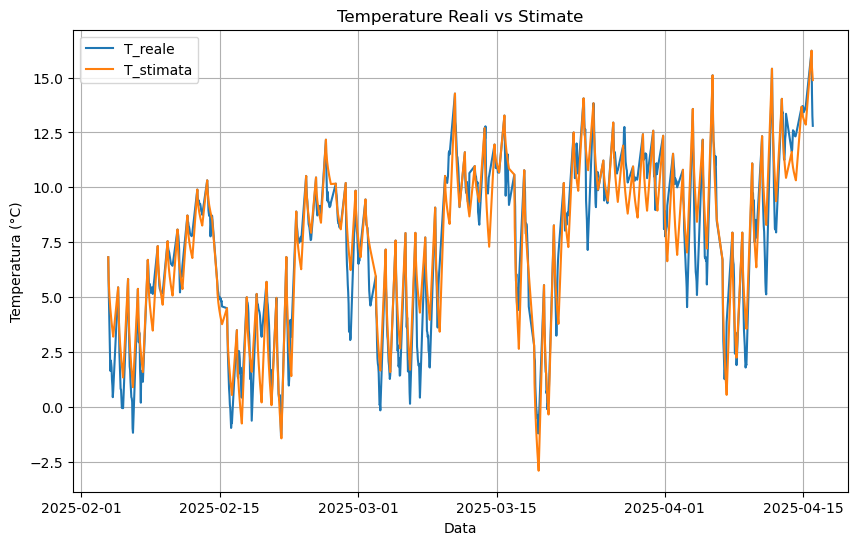

In [41]:
class ModelloTemperatura:
    def __init__(self, combinati_filtrato, tramonto_vicino):
        """Inizializza la classe con i dati e i coefficienti iniziali"""
        self.combinati_filtrato = combinati_filtrato.copy()
        self.tramonto_vicino = tramonto_vicino.copy()
        
        # Coefficienti iniziali
        self.a = 0.1
        self.b = 0.05
        self.c = 0.5

        # Prepara i dati
        self.prepara_dati()

    def prepara_dati(self):
        """Prepara i dati, calcolando Delta_tempo e facendo il merge delle informazioni necessarie"""
        self.combinati_filtrato['Data'] = pd.to_datetime(self.combinati_filtrato['Data'])
        
        # Calcola il tempo trascorso dal tramonto
        self.combinati_filtrato['Delta_tempo'] = (
            (self.combinati_filtrato['Data'] - self.tramonto_vicino['Tramonto_arrotondato'].iloc[0]).dt.total_seconds() / 3600
        ).abs()

        # Raggruppa per ora
        colonne_numeriche = self.combinati_filtrato.select_dtypes(include=['number']).columns
        self.T_reale_oraria = self.combinati_filtrato.set_index('Data')[colonne_numeriche].resample('h').mean().reset_index()
        self.T_reale_oraria.dropna(inplace=True)

        # Aggiunge colonna con data senza orario
        self.T_reale_oraria['Data_numero'] = self.T_reale_oraria['Data'].dt.date
        self.tramonto_vicino['Data_numero'] = self.tramonto_vicino['Tramonto'].dt.date

        # Merge con tramonto arrotondato
        self.T_reale_oraria = self.T_reale_oraria.merge(
            self.tramonto_vicino[['Data_numero', 'Tramonto_arrotondato']], on='Data_numero', how='left'
        )

        self.T_reale_oraria.drop(columns=['Data_numero'], inplace=True)

    def calcola_temperatura_stimata(self):
        decadimento_temperatura = []

        for _, row in self.tramonto_vicino.iterrows():
            T_tramonto = row['St.Meteo/T.Aria (°C)']
            RH_tramonto = row['St.Meteo/Um.Aria (%)']
            orario_tramonto = row['Tramonto_arrotondato']
            k = self.c + self.a * T_tramonto + self.b * RH_tramonto

            # Aggiungere la temperatura reale iniziale
            decadimento_temperatura.append([orario_tramonto, T_tramonto])

            # Generare i valori per le successive 12 ore
            for h in range(1, 13):
                orario_futuro = orario_tramonto + timedelta(hours=h)
                delta_tempo = np.sqrt(h)
                T_stimata = T_tramonto - k * delta_tempo
                decadimento_temperatura.append([orario_futuro, T_stimata])

        # Creazione DataFrame con i risultati
        self.Temp_decadimento = pd.DataFrame(decadimento_temperatura, columns=['Data', 'Temperatura_stimata'])

        # **Debug**: Stampiamo le prime righe per controllare i dati
        print("📊 Contenuto di Temp_decadimento prima del merge:")
        print(self.Temp_decadimento.head())

        # **Correggiamo il merge eliminando i duplicati**
        self.T_reale_oraria = self.T_reale_oraria.merge(self.Temp_decadimento, on='Data', how='left')

        # **Se il merge crea duplicati (_x, _y), eliminiamoli**
        if 'Temperatura_stimata_x' in self.T_reale_oraria.columns:
            self.T_reale_oraria.drop(columns=['Temperatura_stimata_x'], inplace=True)
        if 'Temperatura_stimata_y' in self.T_reale_oraria.columns:
            self.T_reale_oraria.rename(columns={'Temperatura_stimata_y': 'Temperatura_stimata'}, inplace=True)

        # **Debug: Controlliamo che la colonna sia stata creata correttamente**
        if 'Temperatura_stimata' in self.T_reale_oraria.columns:
            print("✅ Colonna 'Temperatura_stimata' creata correttamente!")
        else:
            print("❌ ERRORE: Il merge ha fallito!")
    
        # Rimuoviamo eventuali NaN
        self.T_reale_oraria.dropna(inplace=True)

    def calcola_errore(self):
        """Calcola l'errore tra la temperatura reale e quella stimata"""
        return np.sqrt(np.mean((self.T_reale_oraria['St.Meteo/T.Aria (°C)'] - self.T_reale_oraria['Temperatura_stimata']) ** 2))

    def ottimizza_coeff(self):
        """Ottimizza i coefficienti a, b, c per minimizzare l'errore"""

        def loss_function(params):
            a, b, c = params
            self.a, self.b, self.c = a, b, c
            self.calcola_temperatura_stimata()
            return self.calcola_errore()

        initial_guess = [self.a, self.b, self.c]

        try:
            result_powell = minimize(
                loss_function, 
                initial_guess, 
                method='Powell',  
                options={'maxfev': 5000, 'disp': True}
            )
            print("\n📊 Risultato con Powell:", result_powell)

            if result_powell.success:
                self.a, self.b, self.c = result_powell.x
                print(f"✅ Nuovi coefficienti: a={self.a:.4f}, b={self.b:.4f}, c={self.c:.4f}")
            else:
                print(f"⚠️ Ottimizzazione non riuscita: {result_powell.message}")

        except Exception as e:
            print(f"❌ Errore durante l'ottimizzazione: {e}")

    def aggiorna_fino_a_convergenza(self, soglia=0.01, max_iter=1000):
        errore_prec = float('inf')

        for iterazione in range(max_iter):  
            print(f"\n🔹 Iterazione: {iterazione + 1}")
            self.calcola_temperatura_stimata()

            errore_attuale = self.calcola_errore()
            print(f"Errore attuale: {errore_attuale:.6f}")

            if abs(errore_prec - errore_attuale) < soglia:
                print("🔹 Errore stabile, terminazione dell'ottimizzazione.")
                break

            errore_prec = errore_attuale
            self.ottimizza_coeff()

        # **Salviamo l'errore finale come attributo della classe**
        self.errore_finale = errore_attuale  
        print(f"\n✅ Ottimizzazione completata. Errore finale: {self.errore_finale:.6f}")
 

    def mostra_grafico(self):
        """Grafica le temperature reali e stimate"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.T_reale_oraria['Data'], self.T_reale_oraria['St.Meteo/T.Aria (°C)'], label='T_reale')
        plt.plot(self.T_reale_oraria['Data'], self.T_reale_oraria['Temperatura_stimata'], label='T_stimata')
        plt.title('Temperature Reali vs Stimate')
        plt.xlabel('Data')
        plt.ylabel('Temperatura (°C)')
        plt.legend()
        plt.grid(True)
        plt.show()


modello = ModelloTemperatura(Combinati_filtrato, Tramonto_vicino)
modello.aggiorna_fino_a_convergenza()  # Ottimizza i coefficienti
modello.mostra_grafico()  # Mostra il grafico con i risultati

In [14]:
# INSERIRE UNA QUERY AL DATABASE PER PRENDER I VALORI DI T E RH A PARTIRE DALLE 17

🔍 Errore RMSE del modello: 1.2704
🔍 Coefficienti aggiornati: a=-0.0093, b=-4.3935, c=4.7636
                  Data  Temperatura_stimata  Margine_basso  Margine_alto
0  2026-02-05 18:00:00             6.600000       4.110031      9.089969
1  2026-02-05 19:00:00             5.149314       2.659345      7.639282
2  2026-02-05 20:00:00             4.548419       2.058451      7.038388
3  2026-02-05 21:00:00             4.087337       1.597368      6.577306
4  2026-02-05 22:00:00             3.698627       1.208658      6.188596
5  2026-02-05 23:00:00             3.356166       0.866198      5.846135
6  2026-02-06 00:00:00             3.046558       0.556589      5.536527
7  2026-02-06 01:00:00             2.761844       0.271875      5.251813
8  2026-02-06 02:00:00             2.496839       0.006870      4.986808
9  2026-02-06 03:00:00             2.247941      -0.242028      4.737909
10 2026-02-06 04:00:00             2.012527      -0.477442      4.502495
11 2026-02-06 05:00:00          

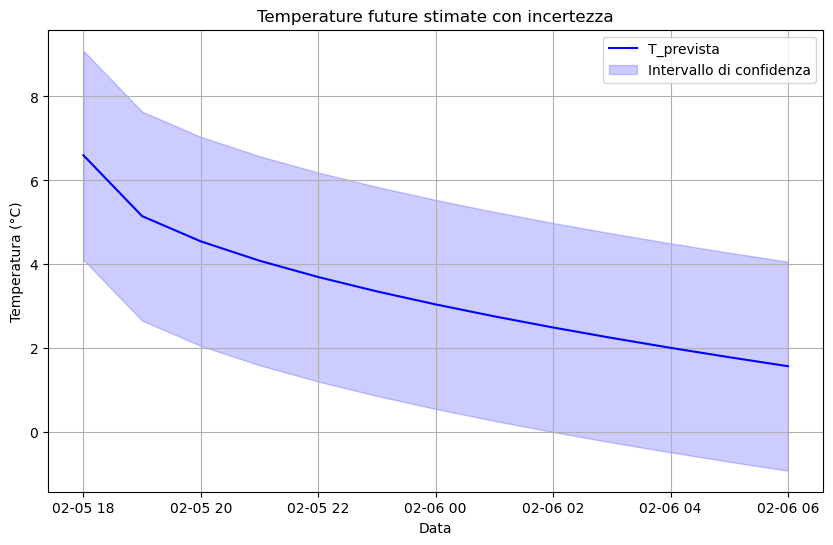

In [43]:
# Creiamo un DataFrame iniziale
Andamento_futuro = pd.DataFrame({
    'Data': np.array(['2026-02-05 18:00:00'], dtype='datetime64'),
    'Temp': np.array([6.6]),
    'RH': np.array([0.74])
})

Andamento_futuro['Data'] = pd.to_datetime(Andamento_futuro['Data'])

# Errore
errore_finale = modello.errore_finale
print(f"🔍 Errore RMSE del modello: {errore_finale:.4f}")

# Definiamo coefficienti a, b, c (esempio, sostituiscili con i tuoi valori reali)
a_ottimizzato = modello.a
b_ottimizzato = modello.b
c_ottimizzato = modello.c

print(f"🔍 Coefficienti aggiornati: a={a_ottimizzato:.4f}, b={b_ottimizzato:.4f}, c={c_ottimizzato:.4f}")

# Creiamo il vettore decadimento_temperatura
decadimento_temperatura = []
for _, row in Andamento_futuro.iterrows():
    T_tramonto = row['Temp']
    RH_tramonto = row['RH']
    orario_tramonto = row['Data']
    k = c_ottimizzato + a_ottimizzato * T_tramonto + b_ottimizzato * RH_tramonto  # Calcolo coefficiente k

    # Aggiungere la temperatura reale iniziale
    decadimento_temperatura.append([orario_tramonto, T_tramonto])

    # Generare i valori per le successive 12 ore
    for h in range(1, 13):
        orario_futuro = orario_tramonto + timedelta(hours=h)
        delta_tempo = np.sqrt(h)
        T_stimata = T_tramonto - k * delta_tempo
        decadimento_temperatura.append([orario_futuro, T_stimata])

# **Convertiamo il vettore decadimento_temperatura in DataFrame**
Decadimento = pd.DataFrame(decadimento_temperatura, columns=['Data', 'Temperatura_stimata'])

# **Definiamo gli intervalli di confidenza con l'errore finale**
Decadimento['Margine_basso'] = Decadimento['Temperatura_stimata'] - 1.96*errore_finale
Decadimento['Margine_alto'] = Decadimento['Temperatura_stimata'] + 1.96*errore_finale

print(Decadimento)
Decadimento.to_csv('C:/Users/lugol/OneDrive/Documenti/Prova_irrigazione/GELATE/Andamento_temperature.csv', index=False) 

# **Plot della temperatura stimata con banda di incertezza**
plt.figure(figsize=(10, 6))
plt.plot(Decadimento['Data'], Decadimento['Temperatura_stimata'], label='T_prevista', color='blue')

# **Aggiunta della banda di incertezza**
plt.fill_between(Decadimento['Data'], Decadimento['Margine_basso'], Decadimento['Margine_alto'],
                 color='blue', alpha=0.2, label='Intervallo di confidenza')

# **Aggiungere etichette e grid**
plt.title('Temperature future stimate con incertezza')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)

# **Mostrare il grafico**
plt.show()